In [65]:
#Import package pandas for data analysis
import pandas as pd
# Import package numpy for numeric computing
import numpy as np
from numpy import int64
from numpy import float64
from numpy import datetime64
# Import package matplotlib for visualisation/plotting
import matplotlib.pyplot as plt
import matplotlib.dates as dates
# Allows plots to appear directly in the notebook.
%matplotlib inline
#forcurvefitting
from scipy.optimize import curve_fit
# For dealing with some Accented characters (in Irish Place names)
import unidecode
# Date/time functionality
import datetime
import time
#for trigonometic calculations
import math
# Check if files exist
from os.path import exists
from os import makedirs
# System specific parameters and functions
import sys
import shutil
# look at some z-scores for inspecting outliers.
from scipy import stats
import seaborn as sb
# lookup lat/long and convert lat/long to national grid references.
#import geopy
#import pyproj

from patsy import dmatrices
from sklearn import metrics
#binary encoding by using the OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import LinearRegression
from sklearn.tree import export_graphviz
#from sklearn.tree import export_text

from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split

#import graphviz
#from graphviz import Source
#to read all CSV files in a folder
import os
import glob
import pickle

#### Functions generated at notebooks that might be useful

In [4]:
#method to read chunks from a file and create a dataframe list.
def get_chunks(x):
    """x=[location, dtypes, datecolumns ,date_parser_func, cols]
    exp:mydateparser = lambda x: pd.to_datetime(x, format="%Y-%m-%d %H:%M:%S")
    exp:dtypes={'TRIPID' :'category','PROGRNUMBER':'int16','STOPPOINTID':'category','PLANNEDTIME_ARR':'int64','PLANNEDTIME_DEP':'int64','ACTUALTIME_ARR':'int64','ACTUALTIME_DEP':'int64','DIFFERENCETIME_ARR':'int64','DIFFERENCETIME_DEP':'int64','LINEID':'category','ROUTEID':'category','DIRECTION':'category','TRIPS_TIME_PROPORTION':'float32','TOTAL_JOURNEY_TIME':'int16','TIME_OF_DAY':'category','DAY_OF_WEEK':'category'}
    exp:cols=['Date time','Temperature','Wind Speed','Precipitation','Cloud Cover']
    exp:x=['/Chunks/DBUS/QP_Implementation',dtypes,['ACTUALTIME_ARR_DATETIME'],mydateparser, cols]"""
    cwd=os.getcwd()
    path = cwd+x[0]
    chunk_folder = glob.glob(os.path.join(path, "*.csv"))
    chunk_list=[]
    counter=0
    for filename in chunk_folder:
        # read the csv file
        if len(x)==4:
            df_chunk = pd.read_csv(filename, low_memory=False, dtype=x[1],parse_dates=x[2],date_parser=x[3])
        else:
            df_chunk = pd.read_csv(filename,usecols=x[4], low_memory=False, dtype=x[1],parse_dates=x[2],date_parser=x[3])
        chunk_list.append(df_chunk)
        print('Index at chunk_list',counter,' is ', filename, ': ',df_chunk.shape)
        counter+=1
    return chunk_list
#chunk_dbus_list=get_chunks(arg_list)

In [5]:
#method to parse dates
mydateparser = lambda x: pd.to_datetime(x, format="%Y-%m-%d %H:%M:%S")

In [6]:
#method that mathes list index in a dataframe list with id information in dataframe's column. 
#for this method to work id column should be constant. 
def id_list_index_matcher(df_list, column_name):
    df_id_list_index = pd.DataFrame()
    index_count=0
    for df in df_list:
        a=df[column_name].unique()
        df_id_list_index=df_id_list_index.append({'List_index':index_count,column_name:a[0]},ignore_index=True)
        index_count+=1
    return df_id_list_index

In [7]:
#methods that create csv files from dataframe list by naming them with unique value in id column.
#for this method to work id column should be constant. 
def write_to_csv(adress,df_list,id_column ):
    cwd=os.getcwd()
    path = cwd+adress
    for df in df_list:
        a=df[id_column].unique()
        file_name=a[0]
        saved_file_name=file_name+'.csv'
        my_file_bool=os.path.exists(path+saved_file_name)
        if my_file_bool==False:
            df.to_csv(path+saved_file_name,index=False)
            print('Location:', path+saved_file_name)

In [8]:
def write_to_csv_n_r_p(adress,df_list,id_column ):
    """without relative path input"""
    path = adress
    for df in df_list:
        a=df[id_column].unique()
        file_name=a[0]
        saved_file_name=file_name+'.csv'
        my_file_bool=os.path.exists(path+saved_file_name)
        if my_file_bool==False:
            df.to_csv(path+saved_file_name,index=False)
            print('Location:', path+saved_file_name)

In [9]:
#method that takes a dataframe list and prints list lenght and sum of all rows in all dataframes
def df_list_checker(dflist):
    print("number of df in list: ",len(dflist))
    row_count=0
    for df in dflist:
        row_count+=df.shape[0]
    print("number of rows of data in list: ", row_count)

In [10]:
#method to yield(return generator object) dfs for memory efficent concat( to avoid expotential memory use)
#https://stackoverflow.com/questions/70911236/how-can-i-concat-the-huge-pandas-dataframes-into-one
def yield_dfs(x):
    """x=[location, dtypes, datecolumns ,date_parser_func]
    exp:mydateparser = lambda x: pd.to_datetime(x, format="%Y-%m-%d %H:%M:%S")
    exp:dtypes={'TRIPID' :'category','PROGRNUMBER':'int16','STOPPOINTID':'category','PLANNEDTIME_ARR':'int64','PLANNEDTIME_DEP':'int64','ACTUALTIME_ARR':'int64','ACTUALTIME_DEP':'int64','DIFFERENCETIME_ARR':'int64','DIFFERENCETIME_DEP':'int64','LINEID':'category','ROUTEID':'category','DIRECTION':'category','TRIPS_TIME_PROPORTION':'float32','TOTAL_JOURNEY_TIME':'int16','TIME_OF_DAY':'category','DAY_OF_WEEK':'category'}
    exp:x=['/Chunks/DBUS/QP_Implementation',dtypes,['ACTUALTIME_ARR_DATETIME'],mydateparser]"""
    cwd=os.getcwd()
    path = cwd+x[0]
    file_list = glob.glob(os.path.join(path, "*.csv"))
    """generator function to yield dataframes."""
    for filename in file_list:
        df = pd.read_csv(filename, low_memory=False, dtype=x[1],parse_dates=x[2],date_parser=x[3],index_col=False)
        print(df.shape)
        yield df

#df_dbus = pd.concat(yield_dfs(x), axis=0,ignore_index=True)

In [11]:
#method that takes a directory and reads all files inside that directory and its subdirectories 
#creates a dataframe from them and add to dataframe list
def get_chunks_subdirectory(location):
    cwd=os.getcwd()
    adress=location
    path = cwd+adress
    chunk_list=[]
    for root, dirnames, files in os.walk(path):
        print(dirnames)
        print('='*66)
        for mfile in files:
            # read the csv file
            df_chunk = pd.read_csv(os.path.join(root, mfile), low_memory=False)
            chunk_list.append(df_chunk)
            print('Location:', mfile)
    return chunk_list
#chunk_dbus_list_v2=get_chunks_subdirectory('/Chunks/DBUS/LINEID_CHUNKS/')

In [12]:
def write_to_csv_if_in_list(adress,df_list,id_column,IMP_List ):
    cwd=os.getcwd()
    path = cwd+adress
    for df in df_list:
        a=df[id_column].unique()
        if a in IMP_List:
            file_name=a[0]
            saved_file_name=file_name+'.csv'
            my_file_bool=os.path.exists(path+saved_file_name)
            if my_file_bool==False:
                df.to_csv(path+saved_file_name,index=False)
                print('Location:', path+saved_file_name)

In [13]:
def get_sourcefeatures(file, ROUTEID):
    df = pd.read_csv(file, low_memory=False)
    targetrow_df= df[df.ROUTEID == ROUTEID ]
    features_list=[]
    for column in targetrow_df.columns.values:
        if targetrow_df.iloc[0][column]==1:
           features_list.append(column)
    features_list.remove('TOTAL_JOURNEY_TIME')
    return features_list

In [14]:
# Define a Helper function to compute/print all our metrics
def printMetrics(actualVal, predictions):
    #classification evaluation measures
    print('\n==============================================================================')
    print("MAE: ", metrics.mean_absolute_error(actualVal, predictions))
    print("MSE: ", metrics.mean_squared_error(actualVal, predictions))
    print("RMSE: ", metrics.mean_squared_error(actualVal, predictions)**0.5)
    print("R²: ", metrics.r2_score(actualVal, predictions))

Adresses

In [15]:
home_path=os.path.normpath(os.getcwd() + os.sep + os.pardir)
home_path

'/home/team8/notebook'

In [16]:
KNNR_results_adress=home_path+ '/Pelin/KNNR_results.csv'
RFR_results_adress=home_path+'/Pelin/RFR_results.csv'
LR_results_adress=home_path+'/Lorna/LinearRegression/LR_results.csv'
SVR_results_adress=home_path+'/Lorna/SupportVectorReg/SVR_results.csv'

Read all results in to dataframe and add them to a list

In [17]:
df_KNNR_results = pd.read_csv(KNNR_results_adress )
df_RFR_results= pd.read_csv(RFR_results_adress)
df_LR_results=pd.read_csv(LR_results_adress)
df_SVR_results=pd.read_csv(SVR_results_adress)
result_dfs_list=[df_KNNR_results,df_RFR_results,df_LR_results,df_SVR_results]

In [18]:
ML_all_results_df=pd.concat(result_dfs_list,axis=0,ignore_index=True)
ML_all_results_df

,MODEL,ROUTEID,MAE,RMSE,R2,Unnamed: 0
0,KNNR,18_3,-616.529366,-859.984878,0.418797,NaN
1,KNNR,67_6,-550.041139,-745.349687,0.361559,NaN
2,KNNR,142_9,-228.832451,-391.511405,-0.041293,NaN
3,KNNR,17_16,-263.662522,-373.965981,0.508656,NaN
4,KNNR,46A_74,-686.994105,-921.246434,0.176678,NaN
...,...,...,...,...,...,...
1107,SVR,17A_14,-484.849436,-859.622138,-0.056804,NaN
1108,SVR,66A_38,-572.846730,-894.234424,0.071860,NaN
1109,SVR,15A_85,-639.639040,-888.527208,0.032354,NaN
1110,SVR,47_136,-677.621276,-1034.886399,0.042095,NaN


In [46]:
ML_best_results_series=ML_all_results_df.groupby(['ROUTEID'])['R2'].max()
ML_best_results_series.head(5)

ROUTEID
102_10    0.495569
102_8     0.566313
102_9     0.515169
104_15    0.508125
104_16    0.559939
Name: R2, dtype: float64

In [20]:
ML_best_results_series_below_treshold=ML_best_results_series[ML_best_results_series <0.2]
print("Below 0.2 R2 treshold: ",ML_best_results_series_below_treshold.value_counts().sum())
ML_best_results_series_negative_R2=ML_best_results_series[ML_best_results_series <0]
print("Negative R2: ",ML_best_results_series_negative_R2.value_counts().sum())

Below 0.2 R2 treshold:  6
Negative R2:  1


In [21]:
ML_routes_below_treshold_R2_df=pd.DataFrame({'R2':ML_best_results_series_below_treshold}).reset_index()

In [22]:
ML_routes_below_treshold_R2_df.to_csv('ML_route_bel_tres_R2_cor01_df.csv',index=False)

In [23]:
ML_best_results_df=pd.DataFrame({'R2':ML_best_results_series}).reset_index()
display(ML_best_results_df.head(5))

,ROUTEID,R2
0,102_10,0.495569
1,102_8,0.566313
2,102_9,0.515169
3,104_15,0.508125
4,104_16,0.559939


In [24]:
ML_best_results_df= ML_best_results_df.merge(ML_all_results_df,how='left', on=['ROUTEID','R2'])
ML_best_results_df

,ROUTEID,R2,MODEL,MAE,RMSE,Unnamed: 0
0,102_10,0.495569,LR,-234.735392,-309.054464,166.0
1,102_8,0.566313,RFR,-346.881391,-484.296210,NaN
2,102_9,0.515169,RFR,-330.603486,-458.201856,NaN
3,104_15,0.508125,RFR,-327.630789,-462.553931,NaN
4,104_16,0.559939,RFR,-308.257507,-487.535611,NaN
...,...,...,...,...,...,...
273,84_28,0.318013,KNNR,-598.654657,-945.636000,NaN
274,84_30,0.569397,RFR,-434.380600,-643.431108,NaN
275,84_31,0.446726,RFR,-491.437343,-758.719924,NaN
276,9_5,0.601301,RFR,-433.823934,-637.427869,NaN


In [25]:
ML_best_results_df.to_csv('ML_best_results_cor01_df.csv',index=False)

In [26]:
ML_best_results_df['MODEL'].value_counts()

RFR     215
LR       48
KNNR     12
SVR       3
Name: MODEL, dtype: int64

In [27]:
df_STOPPOINTID_pairs_vs_ROUTEID = pd.read_csv('STOPPOINTID_pairs_vs_ROUTEID.csv' )

In [28]:
df_STOPPOINTID_pairs_vs_ROUTEID.head(2)

,index,ROUTEID,Beginning_stop,Ending_stop,Weight
0,0,18_3,4359,4360,0.006136
1,1,18_3,4359,4361,0.006136


In [29]:
del df_STOPPOINTID_pairs_vs_ROUTEID['Beginning_stop']
del df_STOPPOINTID_pairs_vs_ROUTEID['Ending_stop']
del df_STOPPOINTID_pairs_vs_ROUTEID['index']
df_STOPPOINTID_pairs_vs_ROUTEID.drop_duplicates(keep='first',inplace=True)
print(df_STOPPOINTID_pairs_vs_ROUTEID.shape)
df_STOPPOINTID_pairs_vs_ROUTEID.head(2)

(278, 2)


,ROUTEID,Weight
0,18_3,0.006136
2016,67_6,0.006391


In [30]:
ML_best_results_weighted_df=pd.DataFrame()
ML_best_results_weighted_df= ML_best_results_df.merge(df_STOPPOINTID_pairs_vs_ROUTEID,how='left', on=['ROUTEID'])

In [31]:
ML_best_results_weighted_df.head(2)

,ROUTEID,R2,MODEL,MAE,RMSE,Unnamed: 0,Weight
0,102_10,0.495569,LR,-234.735392,-309.054464,166.0,0.000468
1,102_8,0.566313,RFR,-346.881391,-484.296210,NaN,0.004511


In [40]:
ML_best_results_weighted_df.shape

(278, 7)

In [41]:
del ML_best_results_weighted_df['Unnamed: 0']

In [50]:
ML_best_results_weighted_df=ML_best_results_weighted_df.sort_values(['Weight'],ascending=False)

In [68]:
paramiterbin, param_cov_iterbin = curve_fit(lambda x,a,b,c: x**a + b*x +c ,  ML_best_results_weighted_df['Weight'], ML_best_results_weighted_df['R2'])
ans2=(ML_best_results_weighted_df['Weight']**paramiterbin[0]+paramiterbin[1]*ML_best_results_weighted_df['Weight']+paramiterbin[2])

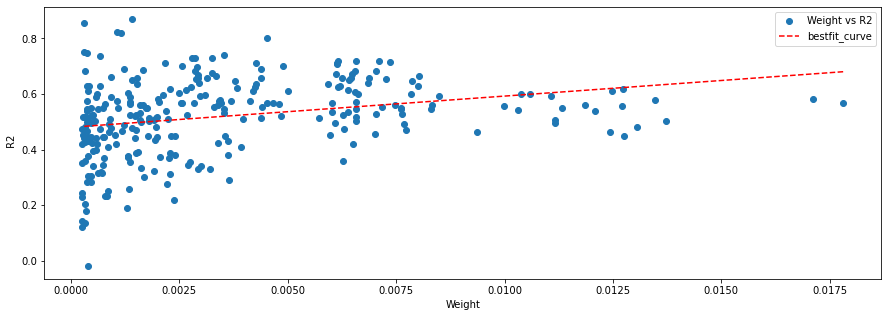

In [71]:
plt.figure(figsize=(15,5))
plt.scatter(ML_best_results_weighted_df['Weight'], ML_best_results_weighted_df['R2'], label = "Weight vs R2")
plt.plot(ML_best_results_weighted_df['Weight'], ans2, '--', color ='red', label ="bestfit_curve")
plt.xlabel("Weight")
plt.ylabel(" R2")
plt.legend()
plt.show()

In [52]:
ML_best_results_weighted_df.to_csv('ML_best_results_weighted.csv',index=False)

In [33]:
ML_best_results_weighted_df.drop_duplicates(keep='first',inplace=True)

In [34]:
weigted_average_r2=np.average(a=ML_best_results_weighted_df['R2'], weights=ML_best_results_weighted_df['Weight'])

In [35]:
weigted_average_r2

0.557078300919352

In [36]:
weigted_average_MAE=np.average(a=ML_best_results_weighted_df['MAE'], weights=ML_best_results_weighted_df['Weight'])

In [37]:
weigted_average_MAE

-405.2072642946061

In [38]:
weigted_average_RMSE=np.average(a=ML_best_results_weighted_df['RMSE'], weights=ML_best_results_weighted_df['Weight'])

In [39]:
weigted_average_RMSE

-596.7337940385931

In [93]:
model=ML_best_results_df['MODEL'][ML_best_results_df.ROUTEID=='102_10'][0]
model

'LR'

In [112]:
KNNR_results_adress=home_path+ '/Pelin/KNNR_results.csv'
RFR_results_adress=home_path+'/Pelin/RFR_results.csv'
LR_results_adress=home_path+'/Lorna/LinearRegression/LR_results.csv'
SVR_results_adress=home_path+'/Lorna/SupportVectorReg/SVR_results.csv'
for ROUTE_IDv2 in ML_best_results_df['ROUTEID'].values:
    model=ML_best_results_df['MODEL'][ML_best_results_df.ROUTEID==ROUTE_IDv2].to_numpy()[0]
    if model=='KNNR':
        pickle_adress='/Pelin/KNNRPickles/'
    elif model=='RFR':
        pickle_adress='/Pelin/RandomForestRegPickles/'
    elif model=='LR':
        pickle_adress='/Lorna/LinearRegression/pickle_files/'
    elif model=='SVR':
        pickle_adress='/Lorna/SupportVectorReg/pickle_files/'
    else: 
        print("Error pickle for ", ROUTE_IDv2," ROUTEID ", model, " model couldn't find in directory" )
    file_name= ROUTE_IDv2 +'.pkl'
    print("filename: ", file_name)
    original_path=home_path+pickle_adress+file_name
    print("original_path: ",original_path)
    target_path=home_path+'/Pelin/Best_Perf_Model_Pickle_Mix/'+file_name
    print("target_path: ",target_path)
    shutil.copyfile(original_path, target_path)

filename:  102_10.pkl
original_path:  /home/team8/notebook/Lorna/LinearRegression/pickle_files/102_10.pkl
target_path:  /home/team8/notebook/Pelin/Best_Perf_Model_Pickle_Mix/102_10.pkl
filename:  102_8.pkl
original_path:  /home/team8/notebook/Pelin/RandomForestRegPickles/102_8.pkl
target_path:  /home/team8/notebook/Pelin/Best_Perf_Model_Pickle_Mix/102_8.pkl
filename:  102_9.pkl
original_path:  /home/team8/notebook/Pelin/RandomForestRegPickles/102_9.pkl
target_path:  /home/team8/notebook/Pelin/Best_Perf_Model_Pickle_Mix/102_9.pkl
filename:  104_15.pkl
original_path:  /home/team8/notebook/Pelin/RandomForestRegPickles/104_15.pkl
target_path:  /home/team8/notebook/Pelin/Best_Perf_Model_Pickle_Mix/104_15.pkl
filename:  104_16.pkl
original_path:  /home/team8/notebook/Pelin/RandomForestRegPickles/104_16.pkl
target_path:  /home/team8/notebook/Pelin/Best_Perf_Model_Pickle_Mix/104_16.pkl
filename:  111_7.pkl
original_path:  /home/team8/notebook/Lorna/LinearRegression/pickle_files/111_7.pkl
targe

filename:  151_16.pkl
original_path:  /home/team8/notebook/Pelin/RandomForestRegPickles/151_16.pkl
target_path:  /home/team8/notebook/Pelin/Best_Perf_Model_Pickle_Mix/151_16.pkl
filename:  151_17.pkl
original_path:  /home/team8/notebook/Pelin/RandomForestRegPickles/151_17.pkl
target_path:  /home/team8/notebook/Pelin/Best_Perf_Model_Pickle_Mix/151_17.pkl
filename:  151_18.pkl
original_path:  /home/team8/notebook/Pelin/RandomForestRegPickles/151_18.pkl
target_path:  /home/team8/notebook/Pelin/Best_Perf_Model_Pickle_Mix/151_18.pkl
filename:  15A_83.pkl
original_path:  /home/team8/notebook/Pelin/RandomForestRegPickles/15A_83.pkl
target_path:  /home/team8/notebook/Pelin/Best_Perf_Model_Pickle_Mix/15A_83.pkl
filename:  15A_84.pkl
original_path:  /home/team8/notebook/Pelin/RandomForestRegPickles/15A_84.pkl
target_path:  /home/team8/notebook/Pelin/Best_Perf_Model_Pickle_Mix/15A_84.pkl
filename:  15A_85.pkl
original_path:  /home/team8/notebook/Pelin/RandomForestRegPickles/15A_85.pkl
target_path

filename:  25B_274.pkl
original_path:  /home/team8/notebook/Pelin/RandomForestRegPickles/25B_274.pkl
target_path:  /home/team8/notebook/Pelin/Best_Perf_Model_Pickle_Mix/25B_274.pkl
filename:  25_269.pkl
original_path:  /home/team8/notebook/Pelin/KNNRPickles/25_269.pkl
target_path:  /home/team8/notebook/Pelin/Best_Perf_Model_Pickle_Mix/25_269.pkl
filename:  25_272.pkl
original_path:  /home/team8/notebook/Pelin/RandomForestRegPickles/25_272.pkl
target_path:  /home/team8/notebook/Pelin/Best_Perf_Model_Pickle_Mix/25_272.pkl
filename:  26_24.pkl
original_path:  /home/team8/notebook/Pelin/RandomForestRegPickles/26_24.pkl
target_path:  /home/team8/notebook/Pelin/Best_Perf_Model_Pickle_Mix/26_24.pkl
filename:  26_26.pkl
original_path:  /home/team8/notebook/Pelin/RandomForestRegPickles/26_26.pkl
target_path:  /home/team8/notebook/Pelin/Best_Perf_Model_Pickle_Mix/26_26.pkl
filename:  26_28.pkl
original_path:  /home/team8/notebook/Pelin/RandomForestRegPickles/26_28.pkl
target_path:  /home/team8/n

filename:  39_23.pkl
original_path:  /home/team8/notebook/Lorna/LinearRegression/pickle_files/39_23.pkl
target_path:  /home/team8/notebook/Pelin/Best_Perf_Model_Pickle_Mix/39_23.pkl
filename:  40B_63.pkl
original_path:  /home/team8/notebook/Pelin/RandomForestRegPickles/40B_63.pkl
target_path:  /home/team8/notebook/Pelin/Best_Perf_Model_Pickle_Mix/40B_63.pkl
filename:  40B_65.pkl
original_path:  /home/team8/notebook/Pelin/RandomForestRegPickles/40B_65.pkl
target_path:  /home/team8/notebook/Pelin/Best_Perf_Model_Pickle_Mix/40B_65.pkl
filename:  40D_102.pkl
original_path:  /home/team8/notebook/Pelin/RandomForestRegPickles/40D_102.pkl
target_path:  /home/team8/notebook/Pelin/Best_Perf_Model_Pickle_Mix/40D_102.pkl
filename:  40D_103.pkl
original_path:  /home/team8/notebook/Pelin/KNNRPickles/40D_103.pkl
target_path:  /home/team8/notebook/Pelin/Best_Perf_Model_Pickle_Mix/40D_103.pkl
filename:  40D_104.pkl
original_path:  /home/team8/notebook/Pelin/RandomForestRegPickles/40D_104.pkl
target_pat

filename:  59_10.pkl
original_path:  /home/team8/notebook/Lorna/LinearRegression/pickle_files/59_10.pkl
target_path:  /home/team8/notebook/Pelin/Best_Perf_Model_Pickle_Mix/59_10.pkl
filename:  59_11.pkl
original_path:  /home/team8/notebook/Lorna/LinearRegression/pickle_files/59_11.pkl
target_path:  /home/team8/notebook/Pelin/Best_Perf_Model_Pickle_Mix/59_11.pkl
filename:  61_106.pkl
original_path:  /home/team8/notebook/Pelin/RandomForestRegPickles/61_106.pkl
target_path:  /home/team8/notebook/Pelin/Best_Perf_Model_Pickle_Mix/61_106.pkl
filename:  61_108.pkl
original_path:  /home/team8/notebook/Pelin/RandomForestRegPickles/61_108.pkl
target_path:  /home/team8/notebook/Pelin/Best_Perf_Model_Pickle_Mix/61_108.pkl
filename:  63_25.pkl
original_path:  /home/team8/notebook/Pelin/RandomForestRegPickles/63_25.pkl
target_path:  /home/team8/notebook/Pelin/Best_Perf_Model_Pickle_Mix/63_25.pkl
filename:  63_26.pkl
original_path:  /home/team8/notebook/Pelin/KNNRPickles/63_26.pkl
target_path:  /home

filename:  77A_28.pkl
original_path:  /home/team8/notebook/Pelin/RandomForestRegPickles/77A_28.pkl
target_path:  /home/team8/notebook/Pelin/Best_Perf_Model_Pickle_Mix/77A_28.pkl
filename:  77A_29.pkl
original_path:  /home/team8/notebook/Pelin/RandomForestRegPickles/77A_29.pkl
target_path:  /home/team8/notebook/Pelin/Best_Perf_Model_Pickle_Mix/77A_29.pkl
filename:  77A_30.pkl
original_path:  /home/team8/notebook/Lorna/LinearRegression/pickle_files/77A_30.pkl
target_path:  /home/team8/notebook/Pelin/Best_Perf_Model_Pickle_Mix/77A_30.pkl
filename:  77A_31.pkl
original_path:  /home/team8/notebook/Pelin/RandomForestRegPickles/77A_31.pkl
target_path:  /home/team8/notebook/Pelin/Best_Perf_Model_Pickle_Mix/77A_31.pkl
filename:  79A_27.pkl
original_path:  /home/team8/notebook/Pelin/RandomForestRegPickles/79A_27.pkl
target_path:  /home/team8/notebook/Pelin/Best_Perf_Model_Pickle_Mix/79A_27.pkl
filename:  79A_28.pkl
original_path:  /home/team8/notebook/Pelin/RandomForestRegPickles/79A_28.pkl
targ